# 1. Loss Functions and Gradients

## 1.1 Binary Classification

As described by http://proceedings.mlr.press/v32/defazio14.pdf 
The binary classification is done through logistic regression

$d_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) $

l2 norm append $\frac{\lambda}{2} \| w \|_2^2 $

l1 norm append $\lambda \| w \|_1 $


In [1]:
import numpy
# x: 1 by d
# w: d by 1
# y: scalar
# lam: scalar
# l1: boolean
# l2: boolean
def logistic_loss(x,w,y,lam,l1=False,l2=False):
    xw = numpy.dot(x,w) # scalar
    yxw = y * xw 
    error = numpy.log(1+numpy.exp(-yxw))
    if l2:
        norm = lam/2 * numpy.linalg.norm(w,ord=2) 
        error += norm 
    elif l1:
        norm = lam * numpy.linalg.norm(w,ord=1)
        error += norm
    return error[0,0]

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)}$

l2 norm: append $2 * \lambda * w$


l1 norm: append $\lambda * sign(w) * w$

In [2]:
# x: 1 by d
# w: d by 1
# y: scalar
# lam: scalar
# l1: boolean
# l2: boolean
def logistic_gradient(x,w,y,lam,l1=False,l2=False):
    yx = y * x
    yxw = numpy.dot(yx,w)
    denominator = 1 + numpy.exp(yxw)
    gradient = -1 * yx.T / denominator
    if l2:
        norm = 2 * lam * w
        gradient += norm
    elif l1:
        norm = lam * numpy.multiply(numpy.sign(w),w)
        gradient += norm
    return gradient

## 1.2 Regression 

### Quadratic/ Linear Regression

Same paper as above outlines the use of quadratic/linear regression as the regression method

$d_i(w) = ||xw-y||_2^2 $

l2: append $\frac{\lambda}{2}||w||_2^2$

l1: append $\lambda||w||_1$

In [3]:
def quadratic_loss(x,w,y,lam,l1=False,l2=False):
    xw = numpy.dot(x,w) # scalar
    error = xw - y
    error = numpy.linalg.norm(error,ord=2)
    if l2:
        norm = lam/2 * numpy.linalg.norm(w,ord=2) 
        error += norm
    if l1:
        norm = lam * numpy.linalg.norm(w,ord=1) 
        error += norm
    return error

$\frac{d_i(w)}{dw}=2x^T(xw-y)$

l2 norm: append $2 * \lambda * w$


l1 norm: append $\lambda * sign(w) * w$

sign is the subgradient of the absolute value

In [4]:
def quadratic_gradient(x,w,y,lam,l1=False,l2=False):
    xw = numpy.dot(x,w)
    gradient = xw - y
    gradient = 2 * gradient * x.T
    if l2:
        norm = 2 * lam * w
        gradient += norm
    if l1: 
        norm = lam * numpy.multiply(numpy.sign(w),w)
        gradient += norm
    return gradient

# 2. SAGA

## 2.1 SAGA algorithm

In [5]:
# X: n by d 
# y: n by 1
# lam: scalar
# stepsize: scalar
# max_epoch: scalar 
# w : d by 1
# gradient_function: 
# loss_function:
# proximal:
# l1: boolean
# l2: boolean
def saga(X,y,lam,stepsize,gradient_function,loss_function,proximal,max_epoch=100,w=None,l1=False,l2=False):
    n , d = X.shape
    if w == None:
        w = numpy.zeros((d,1))
        
    # initialize a table of gradients: n by d
    gradients = numpy.zeros((n,d))
    # fill in table with given weight
    for i in range(n):
        target = X[i].reshape((1,d))
        label = y[i]
        gradients[i] = gradient_function(target,w,label,lam,l1=l1,l2=l2).reshape(d)
        
    epoch_objs = []
        
    for epoch in range(max_epoch):
        # shuffle the entries
        perm = numpy.random.permutation(n)
        X_temp = X[perm] 
        y_temp = y[perm]
        
        obj_val = 0
        
        # for each epoch iterate through the set
        for i in range(n):
            target = X_temp[i].reshape((1,d))
            label = y_temp[i]
            gradient = gradient_function(target,w,label,lam,l1=l1,l2=l2)
            previous_gradient = gradients[perm[i]].reshape((d,1))
            gradients[perm[i]] = gradient.reshape(d)
            
            # update weight
            update = gradient - previous_gradient + numpy.mean(gradients,axis=0).reshape((d,1))
            w = w - stepsize * update
            w = proximal(w)
            
            # add the error
            obj_val += loss_function(target,w,label,lam,l1=l1,l2=l2)
            
        obj_val /= n
        print('Objective Value at epoch ' + str(epoch) + ' is ' + str(obj_val))
        epoch_objs.append(obj_val)
        
    return w,epoch_objs

## 2.2 Helper Functions

Use to graph objective function against epochs and the suboptimal values against epochs.
Suboptimal values are assumed to be the $w^k - w^*$



Note: The paper uses gradients/n for the x axis which I will assume is epochs

In [6]:
import matplotlib.pyplot as plt

def graph(obj_vals,title,l1=False,l2=False):
    epochs = range(len(obj_vals))
    plt.plot(epochs, obj_vals)
    plt.xlabel('Epochs')
    plt.ylabel('Objective Value')
    if l1:
        title += ' L1 Norm'
    if l2: 
        title += ' L2 Norm'
    plt.title(title)
    plt.show()    

def graph_suboptimal(obj_vals,title,l1=False,l2=False,epochs=20):
    minimum = min(obj_vals)
    temp = obj_vals[:20] - minimum
    epochs = range(len(temp))
    plt.plot(epochs, temp)
    plt.xlabel('Epochs')
    plt.ylabel('Suboptimum')
    if l1:
        title += ' L1 Norm'
    if l2: 
        title += ' L2 Norm'
    plt.title(title)
    plt.show()

In [7]:
# create new matrix with normalized rows
def normalize(matrix):
    ret = numpy.zeros(matrix.shape)
    for i in range(len(matrix)):
        vector = matrix[i]
        divisor = numpy.linalg.norm(vector)
        ret[i] = vector / divisor
    return ret

In [8]:
# standardize by variance
def standardize(x_train,x_test):
    # calculate mu and sig using the training set
    d = x_train.shape[1]
    mu = numpy.mean(x_train, axis=0).reshape(1, d)
    sig = numpy.std(x_train, axis=0).reshape(1, d)

    # transform the training features
    x_train = (x_train - mu) / (sig + 1E-6)

    # transform the test features
    x_test = (x_test - mu) / (sig + 1E-6)

    return x_train,x_test

# 3. Datasets

## 3.1 Mnist dataset

Use logistic regression to classify 0-4 and 5-9 as two classes as specified by http://proceedings.mlr.press/v32/defazio14.pdf

http://yann.lecun.com/exdb/mnist/

In [9]:
#https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        array = numpy.frombuffer(f.read(), dtype=numpy.uint8).reshape(shape)
        return array.copy()

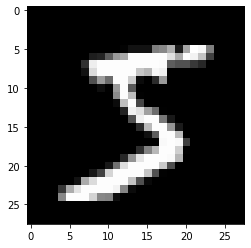

The testing label is 5


In [10]:
import matplotlib.pyplot as plt 

X_test = read_idx("mnist/t10k-images-idx3-ubyte")
y_test = read_idx("mnist/t10k-labels-idx1-ubyte")

X_train = read_idx("mnist/train-images-idx3-ubyte")
y_train = read_idx("mnist/train-labels-idx1-ubyte")


plt.imshow(X_train[0,:,:],cmap='gray')
plt.show()
print('The testing label is ' + str(y_train[0]))

y_train = numpy.array(list(map(lambda x:-1 if x < 5 else 1,y_train)))
y_test = numpy.array(list(map(lambda x:-1 if x <5 else 1, y_test)))


X_train = X_train[:1000,:,:]
y_train = y_train[:1000]
train_n,d,_ = X_train.shape
test_n,_,_ = X_test.shape

X_train = X_train.reshape((train_n,d*d))
X_test = X_test.reshape((test_n,d*d))


y_train = y_train.reshape((train_n,1))
y_test = y_test.reshape((test_n,1))

X_train = normalize(X_train)
X_test = normalize(X_test)

l1 start
Objective Value at epoch 0 is 0.6792847164564335
Objective Value at epoch 1 is 0.6545735244180247
Objective Value at epoch 2 is 0.6331226848633716
Objective Value at epoch 3 is 0.6145247456069555
Objective Value at epoch 4 is 0.5991142245907887
Objective Value at epoch 5 is 0.5853417004788382
Objective Value at epoch 6 is 0.5732457769642615
Objective Value at epoch 7 is 0.5625327953379555
Objective Value at epoch 8 is 0.5529535538077037
Objective Value at epoch 9 is 0.54424529776744
Objective Value at epoch 10 is 0.5364391826430299
Objective Value at epoch 11 is 0.5290604888120721
Objective Value at epoch 12 is 0.5223664114013167
Objective Value at epoch 13 is 0.5163388649750773
Objective Value at epoch 14 is 0.5104226718149082
Objective Value at epoch 15 is 0.5051358853380313
Objective Value at epoch 16 is 0.5000340392648115
Objective Value at epoch 17 is 0.49532398800240884
Objective Value at epoch 18 is 0.4908315376161985
Objective Value at epoch 19 is 0.48658454438608933
O

Objective Value at epoch 162 is 0.3452650127285786
Objective Value at epoch 163 is 0.34495713690687996
Objective Value at epoch 164 is 0.3446390521471766
Objective Value at epoch 165 is 0.3443184794691877
Objective Value at epoch 166 is 0.3440079543289634
Objective Value at epoch 167 is 0.34370295069895357
Objective Value at epoch 168 is 0.3434063013334551
Objective Value at epoch 169 is 0.3431009391138712
Objective Value at epoch 170 is 0.34280402840406865
Objective Value at epoch 171 is 0.3425071120836246
Objective Value at epoch 172 is 0.34220657572344987
Objective Value at epoch 173 is 0.3419177829835399
Objective Value at epoch 174 is 0.3416234352359382
Objective Value at epoch 175 is 0.3413242578702548
Objective Value at epoch 176 is 0.34104026818604616
Objective Value at epoch 177 is 0.3407657046033611
Objective Value at epoch 178 is 0.3404657658044672
Objective Value at epoch 179 is 0.3401849366321044
Objective Value at epoch 180 is 0.33990105480315863
Objective Value at epoch 

Objective Value at epoch 322 is 0.31097364436950886
Objective Value at epoch 323 is 0.31082205097802085
Objective Value at epoch 324 is 0.31066875321395954
Objective Value at epoch 325 is 0.310514591311537
Objective Value at epoch 326 is 0.31035551873703515
Objective Value at epoch 327 is 0.3102066696798986
Objective Value at epoch 328 is 0.31005387664544903
Objective Value at epoch 329 is 0.3099052429527199
Objective Value at epoch 330 is 0.3097606701469242
Objective Value at epoch 331 is 0.3096074451515171
Objective Value at epoch 332 is 0.30945595793295466
Objective Value at epoch 333 is 0.309310382301106
Objective Value at epoch 334 is 0.30916173811916176
Objective Value at epoch 335 is 0.30901618620450755
Objective Value at epoch 336 is 0.3088644627790543
Objective Value at epoch 337 is 0.3087175964759797
Objective Value at epoch 338 is 0.30856672299769466
Objective Value at epoch 339 is 0.3084220990575361
Objective Value at epoch 340 is 0.30827782953851796
Objective Value at epoc

Objective Value at epoch 482 is 0.2908467191424768
Objective Value at epoch 483 is 0.29074816650762203
Objective Value at epoch 484 is 0.29064403510171716
Objective Value at epoch 485 is 0.29053741685214
Objective Value at epoch 486 is 0.29043435445935156
Objective Value at epoch 487 is 0.2903309951218653
Objective Value at epoch 488 is 0.29022690580911115
Objective Value at epoch 489 is 0.29012216510142297
Objective Value at epoch 490 is 0.2900202545132963
Objective Value at epoch 491 is 0.2899163815143738
Objective Value at epoch 492 is 0.289814936017432
Objective Value at epoch 493 is 0.28971499981019866
Objective Value at epoch 494 is 0.28961114712388975
Objective Value at epoch 495 is 0.28950888652080786
Objective Value at epoch 496 is 0.2894066756353417
Objective Value at epoch 497 is 0.289307650360917
Objective Value at epoch 498 is 0.2892056636235101
Objective Value at epoch 499 is 0.2891029500458637
Objective Value at epoch 500 is 0.2890054423503551
Objective Value at epoch 50

Objective Value at epoch 642 is 0.2763200515223034
Objective Value at epoch 643 is 0.27624177999622485
Objective Value at epoch 644 is 0.2761641149058017
Objective Value at epoch 645 is 0.27608023928908937
Objective Value at epoch 646 is 0.2760027484683882
Objective Value at epoch 647 is 0.27592376616821873
Objective Value at epoch 648 is 0.2758430271065535
Objective Value at epoch 649 is 0.27576765036831424
Objective Value at epoch 650 is 0.27568786314192034
Objective Value at epoch 651 is 0.27560769238629185
Objective Value at epoch 652 is 0.27552962802988146
Objective Value at epoch 653 is 0.27545401657962276
Objective Value at epoch 654 is 0.2753748757210939
Objective Value at epoch 655 is 0.27529671138949535
Objective Value at epoch 656 is 0.2752180769175817
Objective Value at epoch 657 is 0.27514220126123945
Objective Value at epoch 658 is 0.27506583336148327
Objective Value at epoch 659 is 0.2749848974382864
Objective Value at epoch 660 is 0.2749118452321084
Objective Value at e

Objective Value at epoch 802 is 0.2649150310327931
Objective Value at epoch 803 is 0.2648521931739307
Objective Value at epoch 804 is 0.26478728372133137
Objective Value at epoch 805 is 0.2647252485578845
Objective Value at epoch 806 is 0.2646625987136467
Objective Value at epoch 807 is 0.2645965868506013
Objective Value at epoch 808 is 0.2645317766396341
Objective Value at epoch 809 is 0.2644710964512022
Objective Value at epoch 810 is 0.26440613576757765
Objective Value at epoch 811 is 0.26434324424326977
Objective Value at epoch 812 is 0.2642772985320506
Objective Value at epoch 813 is 0.26421902982826284
Objective Value at epoch 814 is 0.26415127722634385
Objective Value at epoch 815 is 0.264087875618323
Objective Value at epoch 816 is 0.2640254024397376
Objective Value at epoch 817 is 0.26396243372748557
Objective Value at epoch 818 is 0.2638995167613339
Objective Value at epoch 819 is 0.26383564093756207
Objective Value at epoch 820 is 0.26377427631613326
Objective Value at epoch

Objective Value at epoch 962 is 0.25553372743531144
Objective Value at epoch 963 is 0.2554802252243471
Objective Value at epoch 964 is 0.2554264522366146
Objective Value at epoch 965 is 0.2553723555145166
Objective Value at epoch 966 is 0.2553179148106456
Objective Value at epoch 967 is 0.2552666241046614
Objective Value at epoch 968 is 0.25521113235197146
Objective Value at epoch 969 is 0.2551586533459413
Objective Value at epoch 970 is 0.25510605861719615
Objective Value at epoch 971 is 0.2550515818604424
Objective Value at epoch 972 is 0.2549972606168989
Objective Value at epoch 973 is 0.2549462146973212
Objective Value at epoch 974 is 0.254894506124278
Objective Value at epoch 975 is 0.25484011396072453
Objective Value at epoch 976 is 0.254785757064281
Objective Value at epoch 977 is 0.25473243638824183
Objective Value at epoch 978 is 0.2546798116802484
Objective Value at epoch 979 is 0.25462855722425093
Objective Value at epoch 980 is 0.25457397613227895
Objective Value at epoch 9

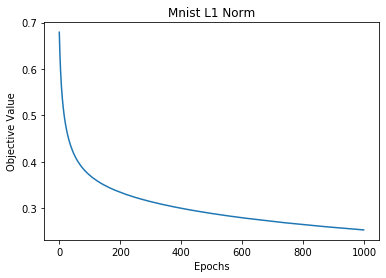

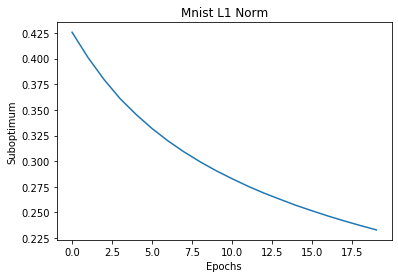

l2 start
Objective Value at epoch 0 is 0.6792503774233187
Objective Value at epoch 1 is 0.6544305033154867
Objective Value at epoch 2 is 0.6325265647085039
Objective Value at epoch 3 is 0.6148307475345728
Objective Value at epoch 4 is 0.5989091319007888
Objective Value at epoch 5 is 0.5853474496383476
Objective Value at epoch 6 is 0.573427687784736
Objective Value at epoch 7 is 0.562748149052328
Objective Value at epoch 8 is 0.5528550121833291
Objective Value at epoch 9 is 0.5442597230227881
Objective Value at epoch 10 is 0.536372090478753
Objective Value at epoch 11 is 0.5290560157410391
Objective Value at epoch 12 is 0.522392052264315
Objective Value at epoch 13 is 0.5161016921140836
Objective Value at epoch 14 is 0.5104053734034703
Objective Value at epoch 15 is 0.5049897202187991
Objective Value at epoch 16 is 0.499893569644867
Objective Value at epoch 17 is 0.4952000771811367
Objective Value at epoch 18 is 0.49069582666328604
Objective Value at epoch 19 is 0.4864568716449476
Objec

Objective Value at epoch 162 is 0.34507668903044847
Objective Value at epoch 163 is 0.3447567330833041
Objective Value at epoch 164 is 0.34446031683015765
Objective Value at epoch 165 is 0.34413950297317486
Objective Value at epoch 166 is 0.3438268261730666
Objective Value at epoch 167 is 0.3435268425490433
Objective Value at epoch 168 is 0.3432103218272925
Objective Value at epoch 169 is 0.3429105393133536
Objective Value at epoch 170 is 0.34261794742459806
Objective Value at epoch 171 is 0.3423082381784782
Objective Value at epoch 172 is 0.3420063648065023
Objective Value at epoch 173 is 0.3417203502022464
Objective Value at epoch 174 is 0.34143332358239736
Objective Value at epoch 175 is 0.34114503037289357
Objective Value at epoch 176 is 0.3408550459951644
Objective Value at epoch 177 is 0.3405658084401241
Objective Value at epoch 178 is 0.3402768838450048
Objective Value at epoch 179 is 0.3399841475578506
Objective Value at epoch 180 is 0.3397005441054836
Objective Value at epoch 

Objective Value at epoch 322 is 0.31076004033232746
Objective Value at epoch 323 is 0.31060892581559646
Objective Value at epoch 324 is 0.31045605764242273
Objective Value at epoch 325 is 0.31030324281241567
Objective Value at epoch 326 is 0.3101511563820263
Objective Value at epoch 327 is 0.30999987592005057
Objective Value at epoch 328 is 0.3098511631131615
Objective Value at epoch 329 is 0.3096962706408324
Objective Value at epoch 330 is 0.309549334975905
Objective Value at epoch 331 is 0.30939612474837974
Objective Value at epoch 332 is 0.3092451315680425
Objective Value at epoch 333 is 0.3090950214956283
Objective Value at epoch 334 is 0.30894473558674346
Objective Value at epoch 335 is 0.308799263526332
Objective Value at epoch 336 is 0.3086563466094133
Objective Value at epoch 337 is 0.3085072384877978
Objective Value at epoch 338 is 0.3083574080109579
Objective Value at epoch 339 is 0.3082104437068447
Objective Value at epoch 340 is 0.30806888787321074
Objective Value at epoch 

Objective Value at epoch 482 is 0.29064603394326977
Objective Value at epoch 483 is 0.2905418096436624
Objective Value at epoch 484 is 0.2904427863358448
Objective Value at epoch 485 is 0.29033436360606146
Objective Value at epoch 486 is 0.2902336601119797
Objective Value at epoch 487 is 0.2901335872907941
Objective Value at epoch 488 is 0.2900252837254594
Objective Value at epoch 489 is 0.2899251386678819
Objective Value at epoch 490 is 0.2898187763169925
Objective Value at epoch 491 is 0.28971448743741895
Objective Value at epoch 492 is 0.28961567793811566
Objective Value at epoch 493 is 0.28951188813906453
Objective Value at epoch 494 is 0.289411589630921
Objective Value at epoch 495 is 0.2893057705199306
Objective Value at epoch 496 is 0.2892078535347632
Objective Value at epoch 497 is 0.289105176415142
Objective Value at epoch 498 is 0.28900457644380995
Objective Value at epoch 499 is 0.2889034752203641
Objective Value at epoch 500 is 0.28880297960635765
Objective Value at epoch 5

Objective Value at epoch 642 is 0.2761426544881654
Objective Value at epoch 643 is 0.2760660153513438
Objective Value at epoch 644 is 0.2759846756791057
Objective Value at epoch 645 is 0.2759059883223374
Objective Value at epoch 646 is 0.27582784298293284
Objective Value at epoch 647 is 0.27574894127466515
Objective Value at epoch 648 is 0.2756687322003544
Objective Value at epoch 649 is 0.2755900603071746
Objective Value at epoch 650 is 0.2755118612786961
Objective Value at epoch 651 is 0.27543532848376107
Objective Value at epoch 652 is 0.27535447464598994
Objective Value at epoch 653 is 0.2752766893965637
Objective Value at epoch 654 is 0.2752016209072326
Objective Value at epoch 655 is 0.27512285678806087
Objective Value at epoch 656 is 0.2750423589868363
Objective Value at epoch 657 is 0.274965449505353
Objective Value at epoch 658 is 0.27488537170383465
Objective Value at epoch 659 is 0.2748078605606438
Objective Value at epoch 660 is 0.27473431425246403
Objective Value at epoch 

Objective Value at epoch 802 is 0.26477481677877873
Objective Value at epoch 803 is 0.26471080422509113
Objective Value at epoch 804 is 0.2646454263864763
Objective Value at epoch 805 is 0.26458142226796244
Objective Value at epoch 806 is 0.264520422617678
Objective Value at epoch 807 is 0.2644563175413163
Objective Value at epoch 808 is 0.2643914540473813
Objective Value at epoch 809 is 0.2643291696592404
Objective Value at epoch 810 is 0.264265714505269
Objective Value at epoch 811 is 0.2641993755687766
Objective Value at epoch 812 is 0.2641374544041883
Objective Value at epoch 813 is 0.2640768839307268
Objective Value at epoch 814 is 0.26401398148405336
Objective Value at epoch 815 is 0.2639496790152814
Objective Value at epoch 816 is 0.2638860684168819
Objective Value at epoch 817 is 0.26382510283437904
Objective Value at epoch 818 is 0.26375975919410477
Objective Value at epoch 819 is 0.26369712123000794
Objective Value at epoch 820 is 0.2636383736305952
Objective Value at epoch 8

Objective Value at epoch 962 is 0.25543460076949676
Objective Value at epoch 963 is 0.25538221099710584
Objective Value at epoch 964 is 0.25532918182656505
Objective Value at epoch 965 is 0.2552748528139236
Objective Value at epoch 966 is 0.25522014870579923
Objective Value at epoch 967 is 0.25516816101494827
Objective Value at epoch 968 is 0.2551160223515284
Objective Value at epoch 969 is 0.25506039141469905
Objective Value at epoch 970 is 0.2550094677016153
Objective Value at epoch 971 is 0.25495670503077467
Objective Value at epoch 972 is 0.2549027304230053
Objective Value at epoch 973 is 0.25484831807148073
Objective Value at epoch 974 is 0.25479864569044675
Objective Value at epoch 975 is 0.25474345692816525
Objective Value at epoch 976 is 0.25469154883713313
Objective Value at epoch 977 is 0.25464003986299366
Objective Value at epoch 978 is 0.2545875420312624
Objective Value at epoch 979 is 0.2545340934835403
Objective Value at epoch 980 is 0.2544825727116412
Objective Value at 

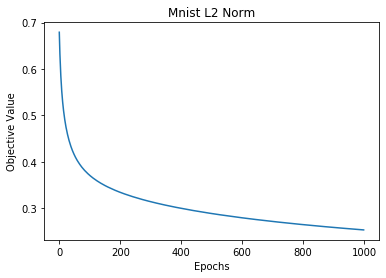

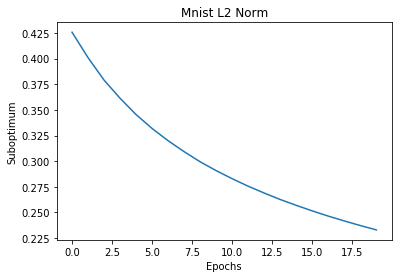

In [11]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(X_train,X_train.T))
L = 1/4 * eigs[0]
n,d = numpy.shape(X_train)
alpha = 1E-6
step_size = 1 / (n * alpha + L)
print('l1 start')
w_mnist_l1, obj_vals_mnist_l1 = saga(X_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l1=True,max_epoch=1000)
graph(obj_vals_mnist_l1,'Mnist',l1=True)
graph_suboptimal(obj_vals_mnist_l1,'Mnist',l1=True)
print('l2 start')
w_mnist_l2, obj_vals_mnist_l2 = saga(X_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l2=True,max_epoch=1000)
graph(obj_vals_mnist_l2,'Mnist',l2=True)
graph_suboptimal(obj_vals_mnist_l2,'Mnist',l2=True)

## 3.2 CovType 

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html

In [74]:
from sklearn import datasets
import numpy

# dataset already scaled
x_sparse, y = datasets.load_svmlight_file('covtype.libsvm.binary.scale')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (581012, 54)
Shape of y: (581012,)


In [75]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 1000
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

l1 start
Objective Value at epoch 0 is 0.22668726416223164
Objective Value at epoch 1 is 0.04839650497134628
Objective Value at epoch 2 is 0.03483686936476029
Objective Value at epoch 3 is 0.030316768194333352
Objective Value at epoch 4 is 0.027108240266333954
Objective Value at epoch 5 is 0.024525626679158082
Objective Value at epoch 6 is 0.022432204106878323
Objective Value at epoch 7 is 0.02065333603693689
Objective Value at epoch 8 is 0.019163833309655584
Objective Value at epoch 9 is 0.01786905764816374
Objective Value at epoch 10 is 0.016743272578404376
Objective Value at epoch 11 is 0.0157722421752991
Objective Value at epoch 12 is 0.014903681198363019
Objective Value at epoch 13 is 0.014133818426648447
Objective Value at epoch 14 is 0.013442522236270434
Objective Value at epoch 15 is 0.012806063744755184
Objective Value at epoch 16 is 0.012239401290888012
Objective Value at epoch 17 is 0.011722037649296208
Objective Value at epoch 18 is 0.011245614567488562
Objective Value at e

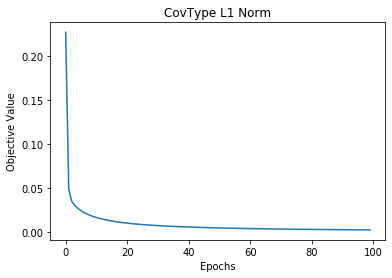

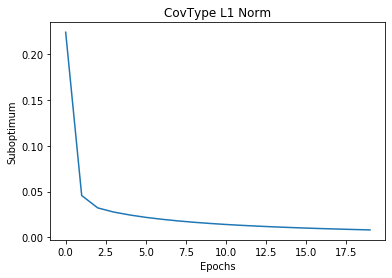

l2 start
Objective Value at epoch 0 is 0.2268780361420825
Objective Value at epoch 1 is 0.04926921557278023
Objective Value at epoch 2 is 0.03545322698762604
Objective Value at epoch 3 is 0.03083748863259878
Objective Value at epoch 4 is 0.02753539519532756
Objective Value at epoch 5 is 0.024828295204721476
Objective Value at epoch 6 is 0.022674488840256433
Objective Value at epoch 7 is 0.020858184774499803
Objective Value at epoch 8 is 0.019328634417750457
Objective Value at epoch 9 is 0.0180199449035019
Objective Value at epoch 10 is 0.016885355355426818
Objective Value at epoch 11 is 0.015901581176344166
Objective Value at epoch 12 is 0.014994544960485632
Objective Value at epoch 13 is 0.014217564679281378
Objective Value at epoch 14 is 0.013510073798025143
Objective Value at epoch 15 is 0.01287654409445728
Objective Value at epoch 16 is 0.01230417002049271
Objective Value at epoch 17 is 0.011773548982186034
Objective Value at epoch 18 is 0.01130643070654802
Objective Value at epoch

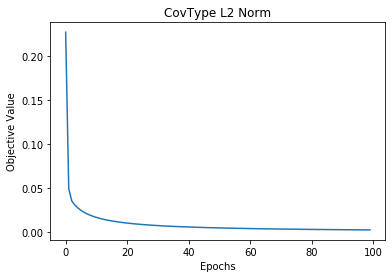

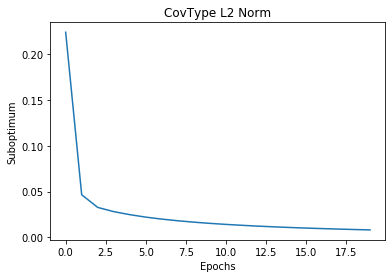

In [76]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(x_train,x_train.T))
L = 1/4 * eigs[0]
n,d = numpy.shape(x_train)
alpha = 1E-6
step_size = 1 / (n * alpha + L)
print('l1 start')
w_cov_l1, obj_vals_cov_l1 = saga(x_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l1=True,max_epoch=100)
graph(obj_vals_cov_l1,'CovType',l1=True)
graph_suboptimal(obj_vals_cov_l1,'CovType',l1=True)
print('l2 start')
w_cov_l2, obj_vals_cov_l2 = saga(x_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l2=True,max_epoch=100)
graph(obj_vals_cov_l2,'CovType',l2=True)
graph_suboptimal(obj_vals_cov_l2,'CovType',l2=True)

## 3.2 IJCNN1

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html

In [79]:
from sklearn import datasets
import numpy

# dataset already scaled
x_sparse, y = datasets.load_svmlight_file('ijcnn1.tr')
x = x_sparse.todense()

rand_indices = numpy.random.permutation(n)
x = x[rand_indices]
y = y[rand_indices]

x_train = x[:1000]
y_train = y[:1000]

x_test = x[1000:]
y_test = y[1000:]

x_train, x_test =standardize(x_train,x_test)

l1 start
Objective Value at epoch 0 is 0.653417529973997
Objective Value at epoch 1 is 0.6069405327196582
Objective Value at epoch 2 is 0.5884628935357512
Objective Value at epoch 3 is 0.5774647958079556
Objective Value at epoch 4 is 0.5692449379528391
Objective Value at epoch 5 is 0.5619643997924624
Objective Value at epoch 6 is 0.5569104038971648
Objective Value at epoch 7 is 0.5520670952420764
Objective Value at epoch 8 is 0.5482202190036783
Objective Value at epoch 9 is 0.5447401633979185
Objective Value at epoch 10 is 0.5416797725465922
Objective Value at epoch 11 is 0.5387281084371851
Objective Value at epoch 12 is 0.5364002218232069
Objective Value at epoch 13 is 0.5339596384206013
Objective Value at epoch 14 is 0.5319718019288836
Objective Value at epoch 15 is 0.5301139450230727
Objective Value at epoch 16 is 0.5283078822546696
Objective Value at epoch 17 is 0.5266819287525255
Objective Value at epoch 18 is 0.5252976632011609
Objective Value at epoch 19 is 0.5240468981669661
Ob

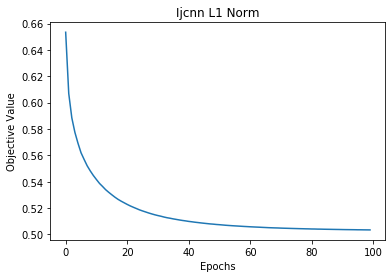

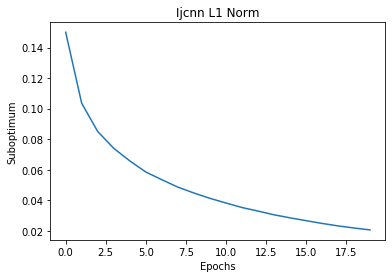

l2 start
Objective Value at epoch 0 is 0.653362522472592
Objective Value at epoch 1 is 0.6072167800891174
Objective Value at epoch 2 is 0.5885742493076334
Objective Value at epoch 3 is 0.5770758547404965
Objective Value at epoch 4 is 0.569134012810044
Objective Value at epoch 5 is 0.5622709158122443
Objective Value at epoch 6 is 0.5568867258856531
Objective Value at epoch 7 is 0.552444262612044
Objective Value at epoch 8 is 0.5482943049138799
Objective Value at epoch 9 is 0.5447500302590571
Objective Value at epoch 10 is 0.541561920141306
Objective Value at epoch 11 is 0.5387966743674254
Objective Value at epoch 12 is 0.5363765656765677
Objective Value at epoch 13 is 0.5341483252506569
Objective Value at epoch 14 is 0.5318930877273984
Objective Value at epoch 15 is 0.5301234672760954
Objective Value at epoch 16 is 0.5284025264056659
Objective Value at epoch 17 is 0.5267377948116243
Objective Value at epoch 18 is 0.5253465126177433
Objective Value at epoch 19 is 0.5239839313033992
Objec

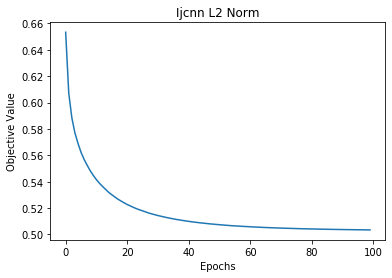

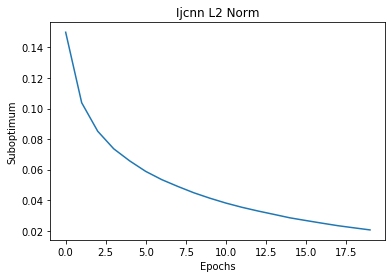

In [80]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(x_train,x_train.T))
L = 1/4 * eigs[0]
n,d = numpy.shape(x_train)
alpha = 1E-6
step_size = 1 / (n * alpha + L)
print('l1 start')
w_cov_l1, obj_vals_ijcnn_l1 = saga(x_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l1=True,max_epoch=100)
graph(obj_vals_ijcnn_l1,'Ijcnn',l1=True)
graph_suboptimal(obj_vals_ijcnn_l1,'Ijcnn',l1=True)
print('l2 start')
w_cov_l2, obj_vals_ijcnn_l2 = saga(x_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l2=True,max_epoch=100)
graph(obj_vals_ijcnn_l2,'Ijcnn',l2=True)
graph_suboptimal(obj_vals_ijcnn_l2,'Ijcnn',l2=True)

## 3.4 Million Songs

https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd

In [21]:
# https://machinelearningmastery.com/load-machine-learning-data-python/
# Load CSV
import numpy

filename = 'YearPredictionMSD'
raw_data = open(filename, 'rt')
data = numpy.loadtxt(raw_data, delimiter=",")
print(data.shape)

n,d = data.shape

permutation = numpy.random.permutation(n)

data = data[permutation]
data = numpy.concatenate((data,numpy.ones((n,1))),axis=1)
n += 1

y = data[:,0]
x = data[:,1:]

x_train = x[:1000]
y_train = y[:1000]

x_test = x[1000:]
y_train = y[1000:]

x_train, x_test = standardize(x_train,x_test)

(515345, 91)


In [22]:
quadratic_loss(x_train[0],numpy.zeros((d,1)),y_train[0],1E-6,l1=True)

2008.0

l1 start
Objective Value at epoch 0 is 1998.6979134727765
Objective Value at epoch 1 is 1998.6887609287855
Objective Value at epoch 2 is 1998.6856851439313
Objective Value at epoch 3 is 1998.687453831924
Objective Value at epoch 4 is 1998.6885521322874
Objective Value at epoch 5 is 1998.689223443927
Objective Value at epoch 6 is 1998.6865596446244
Objective Value at epoch 7 is 1998.6854148876143
Objective Value at epoch 8 is 1998.688852504262
Objective Value at epoch 9 is 1998.6885526859305
Objective Value at epoch 10 is 1998.6885444958348
Objective Value at epoch 11 is 1998.687694029982
Objective Value at epoch 12 is 1998.687533673534
Objective Value at epoch 13 is 1998.6877986757195
Objective Value at epoch 14 is 1998.6869190491668
Objective Value at epoch 15 is 1998.688359214404
Objective Value at epoch 16 is 1998.6876332991817
Objective Value at epoch 17 is 1998.687841094505
Objective Value at epoch 18 is 1998.6885504905363
Objective Value at epoch 19 is 1998.6881210243735
Objectiv

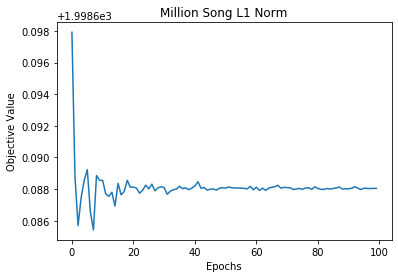

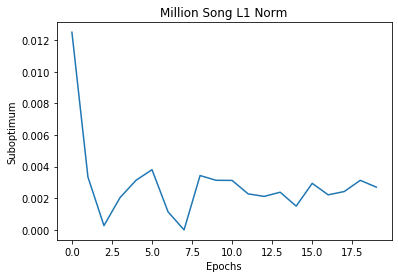

l2 start
Objective Value at epoch 0 is 1998.7015234758562
Objective Value at epoch 1 is 1998.689975054509
Objective Value at epoch 2 is 1998.684767985037
Objective Value at epoch 3 is 1998.6834785738843
Objective Value at epoch 4 is 1998.6934078548961
Objective Value at epoch 5 is 1998.6881943411965
Objective Value at epoch 6 is 1998.6879115763031
Objective Value at epoch 7 is 1998.6887792283414
Objective Value at epoch 8 is 1998.6887020185306
Objective Value at epoch 9 is 1998.6868095401944
Objective Value at epoch 10 is 1998.6883949780856
Objective Value at epoch 11 is 1998.6888028503279
Objective Value at epoch 12 is 1998.6875021547569
Objective Value at epoch 13 is 1998.6886011958309
Objective Value at epoch 14 is 1998.6882800809806
Objective Value at epoch 15 is 1998.688640147798
Objective Value at epoch 16 is 1998.6878423444705
Objective Value at epoch 17 is 1998.6878115943168
Objective Value at epoch 18 is 1998.6880226727824
Objective Value at epoch 19 is 1998.687561350822
Objec

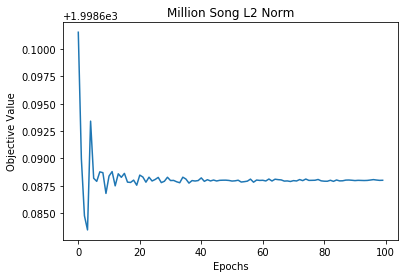

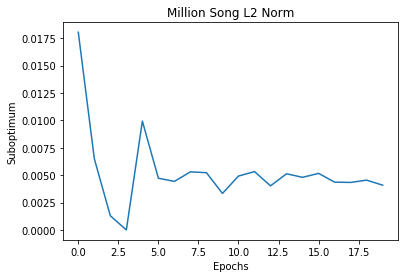

In [24]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(x_train,x_train.T))
L = eigs[0]
n,d = numpy.shape(x_train)
alpha = 1E-6
step_size = 1 / (n * alpha + L)
print('l1 start')
w_cov_l1, obj_vals_song_l1 = saga(x_train,y_train,alpha,step_size,quadratic_gradient,quadratic_loss, proximal,l1=True,max_epoch=100)
graph(obj_vals_song_l1,'Million Song',l1=True)
graph_suboptimal(obj_vals_song_l1,'Million Song',l1=True)
print('l2 start')
w_cov_l2, obj_vals_song_l2 = saga(x_train,y_train,alpha,step_size,quadratic_gradient, quadratic_loss, proximal,l2=True,max_epoch=100)
graph(obj_vals_song_l2,'Million Song',l2=True)
graph_suboptimal(obj_vals_song_l2,'Million Song',l2=True)